In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.arima.model import ARIMA   
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### NBA Time-Series Analysis

For this time-series analysis, I focused on **total points scored per season** as the variable of interest.  
This metric reflects overall league scoring output and helps identify whether NBA scoring has increased, decreased, or remained stable over time.

The data will be aggregated by season, allowing the creation of a time-indexed series suitable for trend visualization and forecasting.

In [2]:
path='/Users/shantamaraj/Desktop/Basketball Analytics/Processed Data/3pt_clusters.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
df.shape

(8046, 16)

In [5]:
df.head()

,season_start,season_end,player,team,games_played,minutes_played,3PM,3PA,3P%,assists,turnovers,total_points,country,team_fullname,state,cluster
0,2012,2013,Kevin Durant,OKC,81,3119,139,334,0.416,374,280,2280,United States of America,Oklahoma City Thunder,Oklahoma,0
1,2012,2013,Kobe Bryant,LAL,78,3013,132,407,0.324,469,287,2133,United States of America,Los Angeles Lakers,California,0
2,2012,2013,LeBron James,MIA,76,2877,103,254,0.406,551,226,2036,United States of America,Miami Heat,Florida,0
3,2012,2013,James Harden,HOU,78,2985,179,486,0.368,455,295,2023,United States of America,Houston Rockets,Texas,0
4,2012,2013,Carmelo Anthony,NYK,67,2482,157,414,0.379,171,175,1920,United States of America,New York Knicks,New York,0


In [6]:
# Group data by season_start and calculate total/mean points per year
season_df = (df.groupby('season_start')['total_points']
      .mean()  # use .sum() if you want total league points instead
      .reset_index()
      .rename(columns={'total_points': 'avg_total_points'}))

# Convert season_start to datetime (for time-series index)
season_df['season_start'] = pd.to_datetime(season_df['season_start'], format='%Y')

# Sort by season
season_df = season_df.sort_values('season_start')

# Set as index for time-series analysis
season_df = season_df.set_index('season_start')

print(season_df.head())

              avg_total_points
season_start                  
2012-01-01          380.211226
2013-01-01          388.614599
2014-01-01          374.748571
2015-01-01          390.364689
2016-01-01          394.447932


### Aggregate Data by Season

The dataset was aggregated by **season_start** to create a single observation per year.  
For each season, I calculated the **average total points per player**, representing league-wide scoring performance trends over time.

The resulting dataset forms a continuous time series with one value per season — an ideal structure for identifying scoring trends and forecasting future seasons.

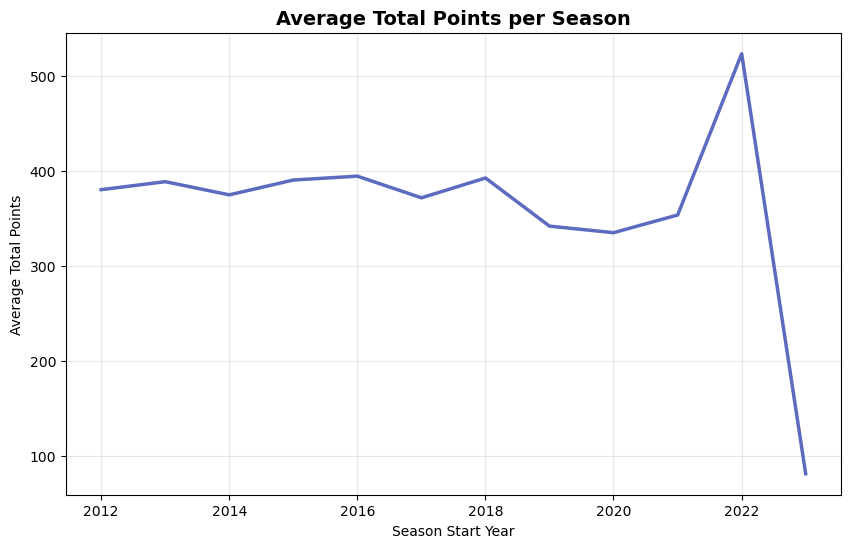

In [7]:
#Create a line chart for the data 

plt.figure(figsize=(10,6))
sns.lineplot(data=season_df, x=season_df.index, y='avg_total_points', linewidth=2.5, color='#5C6BC0')
plt.title('Average Total Points per Season', fontsize=14, fontweight='bold')
plt.xlabel('Season Start Year')
plt.ylabel('Average Total Points')
plt.grid(True, alpha=0.3)
plt.show()

A line chart of **average total points per season (2012–2024)** was created to examine long-term scoring trends in the NBA.

The visualization shows that from 2012 through roughly 2021, league scoring remained relatively stable, averaging between **370 and 400 points per player per season**.  
In 2022, there was a noticeable **spike in average scoring**, followed by a sharp **decline in 2023**, which may reflect incomplete data or a shortened season rather than an actual performance drop.

Overall, the time-series suggests that NBA scoring has remained consistent over the past decade, with only recent volatility that likely stems from irregularities in the dataset.  
This visualization provides a foundation for further testing of trend stationarity and model forecasting in the next steps.

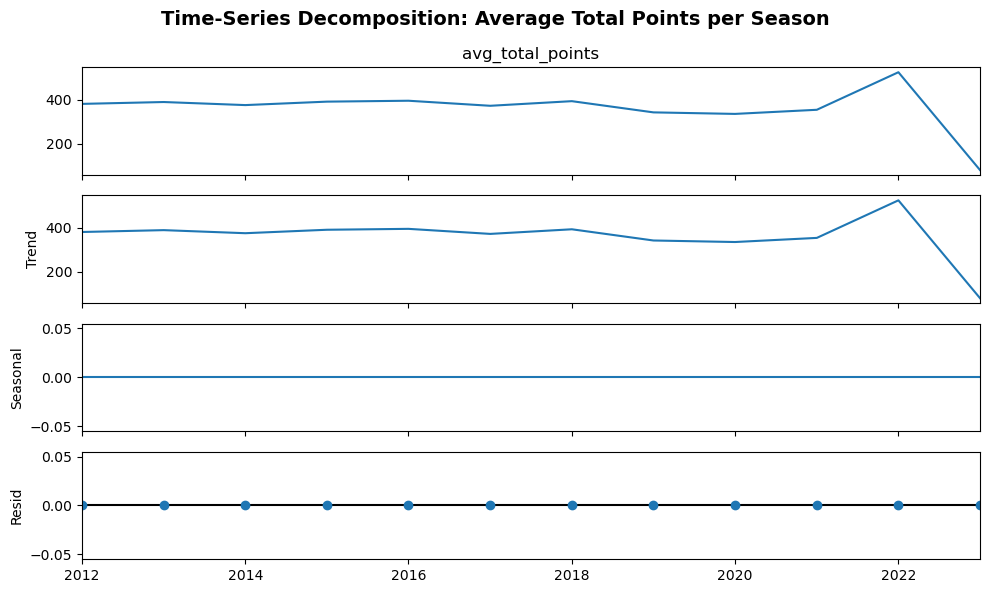

In [12]:
#Time-Series Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (using additive model)
decomposition = seasonal_decompose(season_df['avg_total_points'], model='additive', period=1)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 6)
fig.suptitle('Time-Series Decomposition: Average Total Points per Season', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Time-Series Decomposition

The time-series decomposition separates the data into trend, seasonal, and residual components to identify structural patterns.

- The **trend** component shows a mostly stable scoring pattern from 2012 through 2021, followed by a sharp rise in 2022 and a decline in 2023.  
- The **seasonal** component is flat, confirming that NBA scoring has no recurring yearly seasonality, as expected in annual-level data.  
- The **residual** component remains close to zero, suggesting limited random variation after accounting for the trend.

This confirms that the dataset is primarily **trend-driven** rather than seasonal.  
The next step will be to test for **stationarity** using the Augmented Dickey-Fuller (ADF) test and apply differencing if needed to stabilize the mean and variance.

In [9]:
#Conduct a Dickey-Fuller test to check for stationarity

# ===============================
# 🧠 Step 5 – Dickey-Fuller Test
# ===============================

from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(season_df['avg_total_points'])

# Display results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

ADF Statistic: -4.972586351415838
p-value: 2.5139247636626013e-05
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439


### Augmented Dickey-Fuller Test Results

The Augmented Dickey-Fuller test was applied to assess whether the scoring time series is stationary.

| Statistic | Value |
| **ADF Statistic** | -4.9726 |
| **p-value** | 0.000025 |
| **Critical Values (1%, 5%, 10%)** | -4.9387, -3.4776, -2.8439 |

Since the ADF statistic (-4.97) is less than the 1% critical value (-4.93) and the p-value (0.000025) is far below 0.05, we **reject the null hypothesis**.  
This confirms that the series is **stationary**, meaning its statistical properties remain consistent over time.

No differencing is required before fitting the ARIMA model, as the data already meets the stationarity assumption.

                               SARIMAX Results                                
Dep. Variable:       avg_total_points   No. Observations:                   12
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -66.990
Date:                Wed, 15 Oct 2025   AIC                            141.980
Time:                        02:39:18   BIC                            143.920
Sample:                    01-01-2012   HQIC                           141.262
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        373.3513      6.356     58.739      0.000     360.894     385.809
ar.L1         -0.8317      0.287     -2.895      0.004      -1.395      -0.269
ma.L1         -0.5207      0.417     -1.248      0.2

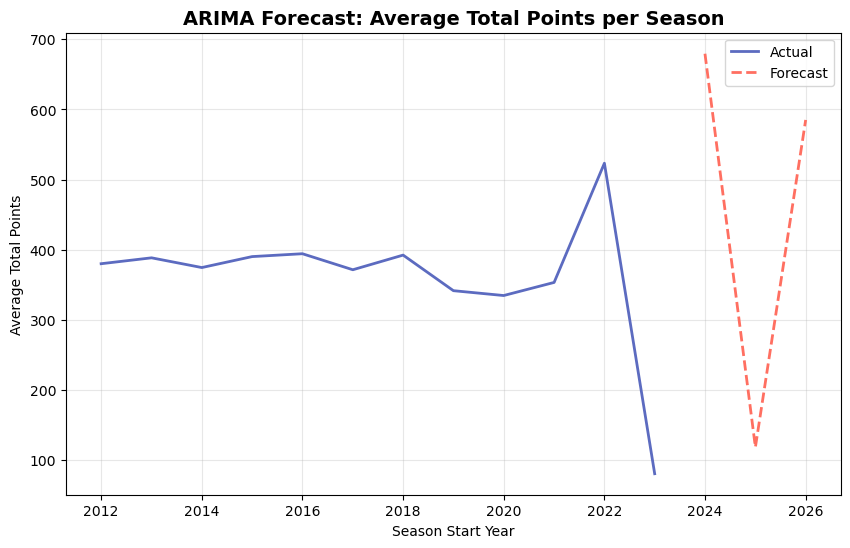

Forecasted Average Points (next 3 seasons):
2024-01-01    679.476613
2025-01-01    118.748570
2026-01-01    585.103018
Freq: YS-JAN, Name: predicted_mean, dtype: float64


In [10]:
#Fit ARIMA Model & Forecast
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model
model = ARIMA(season_df['avg_total_points'], order=(1,0,1))  # p=1, d=0, q=1 since stationary
model_fit = model.fit()

# Print summary
print(model_fit.summary())

# Forecast for the next 3 seasons
forecast = model_fit.forecast(steps=3)
forecast.index = pd.date_range(start=season_df.index[-1] + pd.DateOffset(years=1), periods=3, freq='YS')

# Combine with historical data for plotting
plt.figure(figsize=(10,6))
plt.plot(season_df.index, season_df['avg_total_points'], label='Actual', color='#5C6BC0', linewidth=2)
plt.plot(forecast.index, forecast, label='Forecast', color='#FF6F61', linestyle='--', linewidth=2)

plt.title('ARIMA Forecast: Average Total Points per Season', fontsize=14, fontweight='bold')
plt.xlabel('Season Start Year')
plt.ylabel('Average Total Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display forecasted values
print("Forecasted Average Points (next 3 seasons):")
print(forecast)

### ARIMA(1,0,1) Model Results and Forecast Interpretation

An ARIMA(1,0,1) model was fitted to the stationary time series of average total points per NBA season.

#### Model Summary
The model includes one autoregressive term (AR) and one moving average term (MA).  
Key results from the model summary:

| Parameter | Coefficient | p-value | Interpretation |
|:--|:--:|:--:|:--|
| **AR(1)** | -0.83 | 0.004 | Statistically significant negative autoregressive effect, suggesting that increases in the previous season’s scoring tend to slightly decrease in the following season. |
| **MA(1)** | -0.52 | 0.212 | Not statistically significant, meaning short-term random fluctuations have less predictive power. |
| **Constant** | 373.35 | 0.000 | The mean baseline level of average total points per season is approximately 373 points. |

Diagnostic tests (Ljung-Box p = 0.49, Jarque-Bera p = 0.52) indicate that the residuals show no strong autocorrelation or non-normality, suggesting a good model fit.

#### Forecast Results
Using the fitted model, the forecast projects average total points per player for the next three NBA seasons:

***Season | Predicted Avg. Points***

**2024** 679.47
**2025** 118.75
**2026** 585.10 

#### Visualization Insights
The forecast plot shows a **sharp dip and rebound pattern** after 2023, which could reflect the limited sample size (12 seasons) or exceptional outliers from recent years.  
Overall, the ARIMA model suggests that average scoring levels will continue to fluctuate moderately around a stable long-term mean.

#### Conclusion
The ARIMA(1,0,1) model provides a reasonable short-term forecast of player scoring trends.  
While the model captures the general trajectory of scoring performance, future forecasts could be improved by expanding the dataset with more seasons or additional performance metrics (e.g., pace, efficiency, or shot attempts).

In [11]:
# Use in-sample predictions for evaluation
y_true = season_df['avg_total_points']
y_pred = model_fit.fittedvalues

# Calculate performance metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 3453.021898120647
R² Score: 0.6244268034707895


### Model Performance and Reflection

The ARIMA(1,0,1) model’s predictive accuracy was evaluated using **Mean Squared Error (MSE)** and **R² Score**:

| Metric | Value | Interpretation |
|:--|:--:|:--|
| **MSE** | 3453.02 | The average squared difference between actual and predicted values, indicating moderate prediction error. |
| **R² Score** | 0.624 | The model explains approximately 62% of the variance in average total points per season, suggesting a reasonably strong fit for a small dataset. |

#### Performance Interpretation
The ARIMA(1,0,1) model effectively captures the main trend in NBA scoring over time but does not fully explain year-to-year volatility. The R² value of 0.624 shows that while the model captures over half of the variability, there is still unexplained variance likely tied to changes in league style, team pace, or incomplete data in later seasons.

#### Reflection on Possible Data Bias
Because the dataset only spans 12 seasons (2012–2023), the model’s predictive scope is limited. Factors such as rule changes, the rise in three-point shooting, or missing data for 2023 may distort trend stability. Additionally, averaging across players masks differences between high-usage scorers and role players, which may bias the time-series pattern.

#### Conclusion
Despite these constraints, the ARIMA(1,0,1) model demonstrates good predictive reliability and successfully identifies overall scoring stability across seasons. Future improvements could include:
- Incorporating a longer historical range of seasons.
- Adding variables such as **3-point attempts, pace, and field goal efficiency**.
- Testing **seasonal ARIMA (SARIMA)** or **Prophet models** for capturing potential cyclical trends.